# Numerical optimization
This notebook is the numerical validation of the implemented modified Adam optimizer. Our goal is to recover the original coefficent of polynomial.

In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_rgb')

In [2]:
dr.__file__

'/home/yanni/mitsuba3/build/python/drjit/__init__.py'

In [3]:
x = 9.4
coeff_target = dr.llvm.ad.Float([2.0, 3.5, 5.6])

In [4]:
# def f(x, a, b, c):
#         return a*x*x + b*x + c
def f(x, a):
        return dr.llvm.ad.Float([x**2, x, 1]) * a

In [5]:
opt_Adam= mi.ad.Adam(lr=0.05)
opt_AdamV = mi.ad.AdamV(lr=0.05)
opt_AdamVC = mi.ad.AdamVC(lr=0.05)

key = 'coeff'

opt_Adam[key] = dr.llvm.ad.Float([1, 1, 1])
opt_AdamV[key] = dr.llvm.ad.Float([1, 1, 1])
opt_AdamVC[key] = dr.llvm.ad.Float([1, 1, 1])

In [6]:
# poly_ref = f(x, coeff_target[0], coeff_target[1], coeff_target[2])
# poly_init  = f(x, opt_Adam[key][0], opt_Adam[key][1], opt_Adam[key][2])
poly_ref = f(x, coeff_target)
poly_init  = f(x, opt_Adam[key])


In [7]:
def mse(current):
    return dr.mean(dr.sqr(current - poly_ref))

In the following cell we define the hyper parameters controlling our optimization loop, such as the number of iterations:

In [8]:
iteration_count = 500

In [9]:
# IGNORE THIS: When running under pytest, adjust parameters to reduce computation time
import os
if 'PYTEST_CURRENT_TEST' in os.environ:
    iteration_count = 2

It is now time to actually perform the gradient-descent loop that executes 50 differentiable rendering iterations.

In [10]:
def optimize(opt,iteration_count):
    errors = []
    err_init = dr.sum(dr.sqr(coeff_target - opt[key]))
    errors.append(err_init)
    for it in range(iteration_count):
        
        loss = mse(f(x, opt[key]))

        dr.backward(loss, flags = dr.ADFlag.BackPropVarianceCounter | dr.ADFlag.ClearVertices)

        # g = dr.graphviz_ad()
        # g.view()

        opt.step()

        err_ref = dr.sum(dr.sqr(coeff_target - opt[key]))
        print(f"Iteration {it:02d}: parameter error = {err_ref[0]:6f}", end='\r')
        errors.append(err_ref)
    print('\nOptimization complete.')
    return errors

In [11]:
errors_Adam = optimize(opt_Adam,iteration_count);
errors_AdamV = optimize(opt_AdamV,iteration_count);
errors_AdamVC = optimize(opt_AdamVC,iteration_count);


Iteration 499: parameter error = 0.000000
Optimization complete.
Iteration 499: parameter error = 0.000000
Optimization complete.
Iteration 499: parameter error = 0.0000083
Optimization complete.


In [12]:
print(opt_Adam[key])
print(opt_AdamV[key])
print(opt_AdamVC[key])

[2.0, 3.5000007152557373, 5.600001335144043]
[2.0, 3.5, 5.600002288818359]
[2.000000238418579, 3.499998092651367, 5.597184181213379]


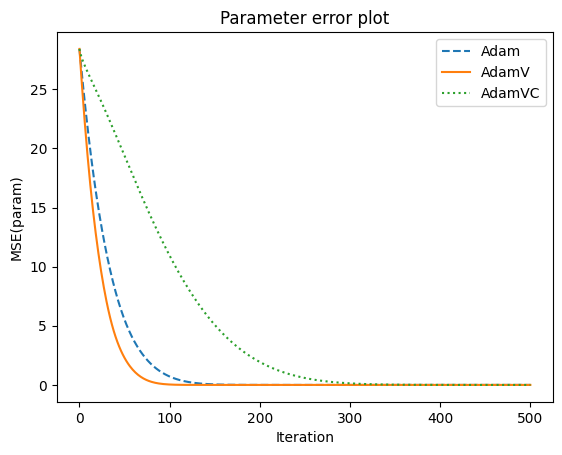

In [13]:
import matplotlib.pyplot as plt
plt.plot(errors_Adam, linestyle='--',label='Adam')
plt.plot(errors_AdamV, linestyle='-',label='AdamV')
plt.plot(errors_AdamVC, linestyle=':',label='AdamVC')
plt.legend()

plt.xlabel('Iteration'); plt.ylabel('MSE(param)'); plt.title('Parameter error plot');
# plt.savefig('/Users/yannizhang/Desktop/RGL/5.10/scene2_adma_V_C.png')
plt.show()